In [4]:
%load_ext autoreload
%autoreload 2

import gym

from src.environments.MultiEnv import MultiEnv

from matplotlib import pyplot as plt
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class Actor(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.model(x)
    
class Critic(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

class Memory:
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def add(self, log_prob, value, done, reward):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
        self.rewards.append(reward)
    
    def clear(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def __len__(self):
        return len(self.log_probs)

In [7]:
def update(mem, next_state):
    q_values = []

    # Do not add this one as it's for the next state
    running_reward = critic(torch.tensor(next_state).float().to(device)).squeeze(dim=1)

    for reward, done in zip(reversed(mem.rewards), reversed(mem.dones)):
        mask = torch.from_numpy(np.array(1 - done)).float().to(device)
        reward = torch.from_numpy(np.array(reward)).float().to(device)

        running_reward = (reward + gamma * running_reward) * mask
        q_values.append(running_reward)

    values = torch.stack(mem.values).squeeze(dim=2).to(device)
    log_probs = torch.stack(mem.log_probs).to(device)
    q_values = torch.stack(q_values).to(device)

    advantage = q_values - values

    critic_loss = torch.pow(advantage, 2).mean()
    actor_loss = (-log_probs * advantage).sum(dim=0).mean()

    critic_optim.zero_grad()
    critic_loss.backward(retain_graph=True)
    critic_optim.step()

    actor_optim.zero_grad()
    actor_loss.backward(retain_graph=True)
    actor_optim.step()

In [8]:
env_name = "CartPole-v1"
env = gym.make(env_name)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [9]:
win_condition = 200

num_episodes = 500
bootstrap_len = 5

gamma = 0.99

In [10]:
mem = Memory()

actor = Actor(state_space, action_space).to(device)
critic = Critic(state_space).to(device)

actor_optim = optim.Adam(actor.parameters(), lr=1e-3)
critic_optim = optim.Adam(critic.parameters(), lr=1e-3)

In [11]:
env = MultiEnv(env_name, 5)

In [12]:
score_log = []
average_score_log = []
running_scores = deque(maxlen=100)

for i in range(num_episodes):
    state = env.reset()
    steps = 0
    score = 0
    
    while True:
        steps += 1

        value = critic(torch.tensor(state).float().to(device))
        logits = F.softmax(actor(torch.tensor(state).float().to(device)))

        probabilities = Categorical(logits)
        action = probabilities.sample()
        log_probs = probabilities.log_prob(action)

        next_state, reward, done, _ = env.step(action.cpu().numpy())
        score += reward

        mem.add(log_probs, value, done, reward)

        if (done.any() or steps % bootstrap_len == 0):
            update(mem, next_state)
            mem.clear()
        
        if done.any():
            break
        
        state = next_state

    score_log.append(score[0])
    running_scores.append(score[0])
    average_score_log.append(np.mean(running_scores))
    
    print("\r Episode: {:.3f}\tAverage Score {:.3f}\tReward: {:.3f}".format(i, np.mean(running_scores), score[0]), end="")
    if (i % 50 == 0):
        print("\r Episode: {:.3f}\tAverage Score {:.3f}\tReward: {:.3f}".format(i, np.mean(running_scores), score[0]))

    if np.mean(running_scores) > win_condition:
        print("Environment Solved!")
        break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


 Episode: 0.000	Average Score 14.000	Reward: 14.000
 Episode: 50.000	Average Score 11.333	Reward: 8.0000
 Episode: 100.000	Average Score 12.580	Reward: 14.000
 Episode: 150.000	Average Score 18.200	Reward: 30.000
 Episode: 200.000	Average Score 27.670	Reward: 31.000
 Episode: 250.000	Average Score 43.790	Reward: 93.0000
 Episode: 300.000	Average Score 150.790	Reward: 400.000
 Episode: 315.000	Average Score 204.470	Reward: 500.000Environment Solved!


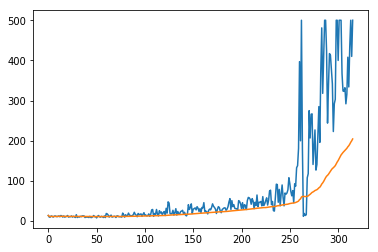

In [13]:
plt.plot(score_log)
plt.plot(average_score_log)